In Wang et al. (2009) they estimate the divergence starting from the estimate
$$KL(p||q) \approx \frac{1}{n} \sum\limits_{i=1}^n \log \frac{\hat{p}(X_i)}{\hat{q}(X_i)}$$ 
They they estimate $\hat{p}(X_i)$ and $\hat{q}(X_i)$ using the $k$ Nearest Neighbor method to ultimately get
$$KL(p||q) \approx = \frac{d}{n} \sum\limits_{i=1}^n \log \frac{\nu_k(i)}{\rho_k(X_i)} + \log \frac{m}{n-1}$$
__However in our case, we don't need to estimate $\hat{q}(X_i)$ since $q$ in our case is just a multivariate Gaussian.__

In this notebook I will implement the new KL estimator and verify that it works for a handful of cases

In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

In [4]:
def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

In [5]:
def KL_Xq(X, q, k=10): 
    ''' X is a matrix, k is float, q is a function 
    '''
    try: 
        n, d = X.shape
    except ValueError: 
        n, d = X.reshape(-1,1).shape

    p_Xi = hat_p(X, k=k)
    q_Xi = q(X)
    return np.sum(np.log(p_Xi) - np.log(q_Xi))/n

In [22]:
ns = np.array([1e2, 1e3, 2e3, 3e3, 4e3, 1e4])#, 1e5])
ns = ns.astype(int)

In [7]:
qX = lambda x: multinorm.pdf(x, mean=0., cov=1.)
kls = [] 
for n in ns: 
    Xn = np.random.normal(0., 1., size=int(n))#mvn([0.], [1.], size=int(n))
    kls.append(KL_Xq(Xn.reshape(-1,1), qX, k=50))

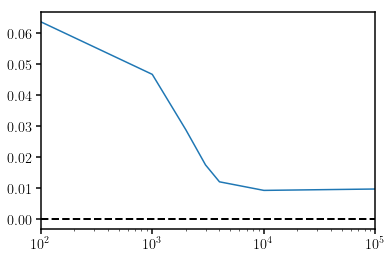

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlim([1e2, 1e5])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')

In [9]:
mu_p = np.array([0.1, 0.3, 0.6, 0.9])
mu_q = np.array([0., 0., 0., 0.])
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.5
            cov_q[i,j] = 0.1

In [10]:
qX = lambda x: multinorm.pdf(x, mean=mu_p, cov=cov_p)
kls = [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    kls.append(KL_Xq(Xn, qX, k=50))

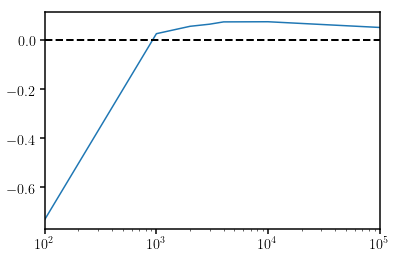

In [11]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlim([1e2, 1e5])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')

In [12]:
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)
kls = [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    kls.append(KL_Xq(Xn, qX, k=50))

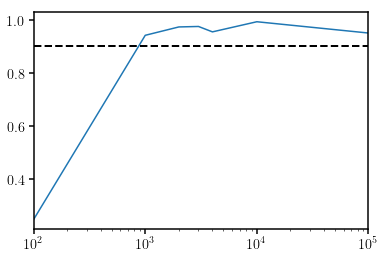

In [13]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, kls)
sub.set_xlim([1e2, 1e5])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0.9009, 0.9009], c='k', lw=2, ls='--')

In [98]:
mu_p = np.zeros(20)
mu_q = np.zeros(20)
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.2
            cov_q[i,j] = 0.2

In [99]:
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)

(-5.0, 1)

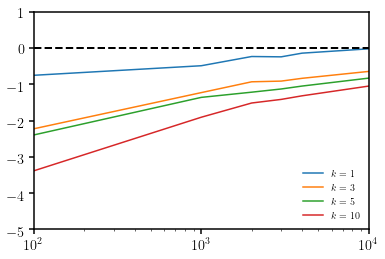

In [101]:
fig = plt.figure()
sub = fig.add_subplot(111)
for k in [1, 3, 5, 10]: 
    kls = [] 
    for n in ns: 
        Xn = mvn(mu_p, cov_p, size=int(n))
        kls.append(KL_Xq(Xn, qX, k=k))
    sub.plot(ns, kls, label=r'$k='+str(k)+'$')
sub.legend(loc='lower right')
sub.set_xlim([1e2, 1e4])
sub.set_xscale("log")
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')
sub.set_ylim([-5., 1])

In [39]:
def hat_q(X, Y, k=1): 
    _, d = X.shape # n and dimensions
    m, _ = Y.shape 
    k, m, d = float(k), float(m), float(d)

    # kNN term
    NN_Y = NearestNeighbors(n_neighbors=int(k)).fit(Y)
    dNN_XY, _ = NN_Y.kneighbors(X, n_neighbors=int(k)) # k+1 to exclude itself
    nu_k_i = dNN_XY[:,-1]
    
    return k/m * 1 / (c_1(d) * nu_k_i**d)

In [61]:
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)

-27.01545394070335


In [95]:
n = 10000 
Xn = mvn(mu_p, cov_p, size=n)
qX = lambda x: multinorm.pdf(x, mean=mu_q, cov=cov_q)

log_q_n = []
log_q_n_1NN = [] 
log_q_n_3NN = [] 
log_q_n_5NN = [] 
log_q_n_10NN = []
log_q_n_20NN = []

for m in ns: 
    Ym = mvn(mu_q, cov_q, size=m)

    hat_q_1NN = hat_q(Xn, Ym, k=1)
    hat_q_3NN = hat_q(Xn, Ym, k=3)
    hat_q_5NN = hat_q(Xn, Ym, k=5)
    hat_q_10NN = hat_q(Xn, Ym, k=10)
    hat_q_20NN = hat_q(Xn, Ym, k=20)

    log_q_n.append(np.sum(np.log(qX(Xn)))/float(n))
    log_q_n_1NN.append(np.sum(np.log(hat_q_1NN))/float(n))
    log_q_n_3NN.append(np.sum(np.log(hat_q_3NN))/float(n))
    log_q_n_5NN.append(np.sum(np.log(hat_q_5NN))/float(n))
    log_q_n_10NN.append(np.sum(np.log(hat_q_10NN))/float(n))
    log_q_n_20NN.append(np.sum(np.log(hat_q_20NN))/float(n))

(-30.0, -25)

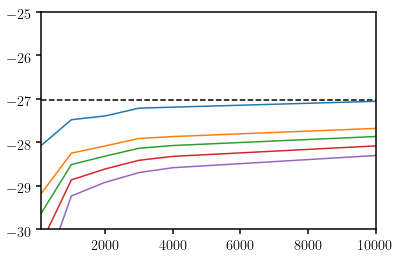

In [96]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, log_q_n, color='k', linestyle='--')
sub.plot(ns, log_q_n_1NN)
sub.plot(ns, log_q_n_3NN)
sub.plot(ns, log_q_n_5NN)
sub.plot(ns, log_q_n_10NN)
sub.plot(ns, log_q_n_20NN)
sub.set_xlim([ns[0], ns[-1]])
sub.set_ylim([-30., -25])

In [92]:
from scipy.special import digamma

(-30, -25)

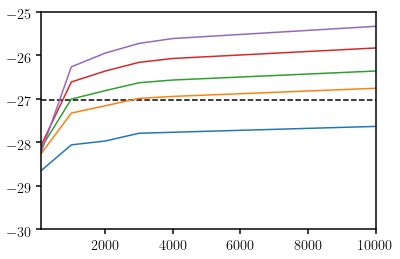

In [97]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, log_q_n, color='k', linestyle='--')
sub.plot(ns, log_q_n_1NN + digamma(1.))# - np.log(1) + np.log(c_1(Xn.shape[1])))
sub.plot(ns, log_q_n_3NN + digamma(3.))# - np.log(3) + np.log(c_1(Xn.shape[1])))
sub.plot(ns, log_q_n_5NN + digamma(5.))# - np.log(5) + np.log(c_1(Xn.shape[1])))
sub.plot(ns, log_q_n_10NN + digamma(10.))# - np.log(10) + np.log(c_1(Xn.shape[1])))
sub.plot(ns, log_q_n_20NN + digamma(20.))# - np.log(10) + np.log(c_1(Xn.shape[1])))
sub.set_xlim([ns[0], ns[-1]])
sub.set_ylim([-30, -25])

In [102]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

In [103]:
n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

37 dimensional data with 2048 samples


In [106]:
# reference Gaussian X 
X_ref = mvn(np.zeros(dim), C_x, size=n)
qX_ref = lambda x: multinorm.pdf(x, mean=np.zeros(dim), cov=C_x)

In [116]:
np.log(c_1(37))

-16.683583620747193

[-3.1652870415329124, -2.7141724451793054, -2.509943752859428, -2.24142704502771, -2.0217724908641417]
[-3.337744568369356, -2.8891504564431534, -2.64665225525089, -2.3563678925336276, -2.125111293764273]


(-5.0, 1)

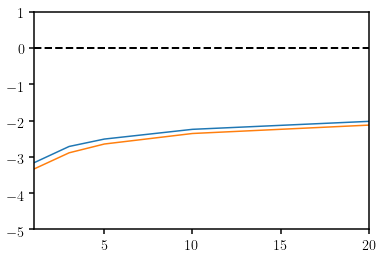

In [114]:
fig = plt.figure()
sub = fig.add_subplot(111)
kls = []
for k in [1, 3, 5, 10, 20]: 
    kls.append(KL_Xq(X_ref, qX_ref, k=k) + digamma(k))
sub.plot([1, 3, 5, 10, 20], kls)
print kls

kls = []
for k in [1, 3, 5, 10, 20]: 
    kls.append(KL_Xq(X_w, qX_ref, k=k) + digamma(k))
sub.plot([1, 3, 5, 10, 20], kls)
print kls

sub.legend(loc='lower right')
sub.set_xlim([1, 20])
sub.plot(sub.get_xlim(), [0., 0.], c='k', lw=2, ls='--')
sub.set_ylim([-5., 1])

In [117]:
from scipy.special import gamma

In [118]:
gamma(5)**2/(gamma(4)*gamma(3))

0.5